In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix 
from sklearn.metrics import roc_curve, auc

## Question 1 Load

In order to better understand the original dataset itself, in this structure analysis, I will check null values column first, simply remove columns that are all null values and after understanding the raw structure of data, I will fill in other columns with partial null values. Also, I will conduct EDA of each column and provide some visualizations to aid in understanding. Let's take a look at how I get to know this data!

### 1. Load naive dataset

In [2]:
# Load dataset
data_v0 = pd.read_json('transactions.txt', lines= True)

In [3]:
data_v0.replace('', np.nan, inplace = True)

In [4]:
data_v0.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


### 2. Naive Dataset Dimension

In [5]:
# Dataset Dimension
m,n = data_v0.shape
print('Dataset Size is:', m, 'x',n )

Dataset Size is: 786363 x 29


### 3. Dataset Information Check

In [6]:
# Null value, data type check
data_v0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                781801 non-null  object 
 8   merchantCountryCode       785639 non-null  object 
 9   posEntryMode              782309 non-null  object 
 10  posConditionCode          785954 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

#### Finding: 

Through dataset information, I have found that there are 6 columns with completely null values. Let's create a ranking dataframe to check.

In [7]:
pd.DataFrame(data_v0.isnull().sum()).reset_index(drop=False).sort_values(by=0,ascending=False)

,index,0
26,recurringAuthInd,786363
25,posOnPremises,786363
23,merchantZip,786363
22,merchantState,786363
21,merchantCity,786363
19,echoBuffer,786363
7,acqCountry,4562
9,posEntryMode,4054
8,merchantCountryCode,724
18,transactionType,698


#### Finding: 

(1) acqCountry has 4562 null values

(2) posEntryMode has 4054 null values

(3) merchantCountryCode has 724 null values

(4) transactionType	has 698 null values

(5) posConditionCode	has 409 null values

Now, I plan to remove these 6 columns('echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd') including all Null values in the dataset to reduce dimensionality.

In [8]:
data_v0.drop(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], 
          axis=1, inplace=True)

In [9]:
# After removing dataset dimension
m,n = data_v0.shape
print('Now, Dataset Size is:', m, 'x',n )

Now, Dataset Size is: 786363 x 23


### 4. Ensure accountNumber and customerId one-to-one correspondence

In [10]:
# Check accountNumber and customerId one-to-one correspondence
dif_c = list(data_v0['accountNumber'].unique() == data_v0['customerId'].unique())
dif_c_num = 0
for i in dif_c:
    if i == 'False':
        dif_c_num += 1
print(dif_c_num)

0


In [11]:
# The number of customers
one_to_one = pd.concat([pd.DataFrame(data_v0['accountNumber'].unique()),
                      pd.DataFrame(data_v0['customerId'].unique())],
                      axis = 1)
one_to_one.columns=['accountNumber','customerId']
one_to_one[one_to_one['accountNumber']==one_to_one['customerId']].shape[0]

5000

#### Finding: 

Each accountNumber and customerId have a one-to-one correspondence, meaning that each customerId has one accountNumber. The total number of customers is 5,000.

### 5. The number of records about each accountNumber/customerId 
### Transaction Number and Transaction Type Analysis
##### Attention: Transaction Type has null value

In [12]:
# Including all transactions
customer_transaction_num = pd.DataFrame(data_v0.groupby('accountNumber')['transactionAmount'].count())
customer_transaction_num.columns = ['transactionNum']
customer_transaction_num

,transactionNum
accountNumber,
100088067,75
100108752,18
100328049,103
100663626,31
100737756,178
...,...
999086814,677
999257059,160
999258704,88


In [13]:
# Statistical information about customer transaction amount
customer_transaction_num.describe()

,transactionNum
count,5000.00000
mean,157.27260
std,655.30506
min,1.00000
25%,21.00000
50%,50.00000
75%,123.00000
max,32850.00000


In [14]:
# The number of customers who had 32580 transactions
customer_transaction_num[customer_transaction_num['transactionNum']==32850].shape[0]

1

#### Finding: 

(1) The minimum cstomer transaction transaction is 1, and the maximum is 32,850 transactions, so big number, amazing, but only one customer!

(2) The lower quartile of the data is 21 transactions, the mean is 157 transactions with a standard deviation of 655, the median is 50 transactions, and the upper quartile is 123 transactions. 

In [15]:
data_v0['transactionType'].unique()

array(['PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL', nan], dtype=object)

In [16]:
# The number of transactionType 
transactionType_num = data_v0['transactionType'].value_counts()
transactionType_num

PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
Name: transactionType, dtype: int64

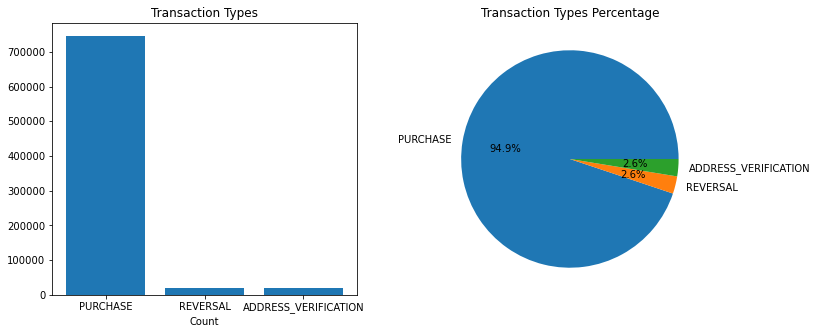

In [17]:
# Define
transaction_types = ["PURCHASE", "REVERSAL", "ADDRESS_VERIFICATION"]
transaction_counts = [745891, 20303, 20169]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Horizontal bar chart
ax1.bar(transaction_types, transaction_counts)
ax1.set_xlabel("Count")
ax1.set_title("Transaction Types")

# Pie chart
ax2.pie(transaction_counts, labels=transaction_types, autopct="%1.1f%%")
ax2.set_title("Transaction Types Percentage")

plt.show()

#### Finding: 

The majority of transactions(94.8%) are purchase, while reversals(2.6%) and address verifications(2.6%) are relative infrequent.

#### transactionType null value fill in
##### Based on the analysis of the 'transactionType' column in the previous section, where 94.8% of the values belong to 'PURCHASE', I decide to fill the 698 null values in the 'transactionType' column with 'PURCHASE'.

In [18]:
data_v0['transactionType'] = data_v0['transactionType'].fillna(value='PURCHASE')
data_v0['transactionType'].value_counts()

PURCHASE                745891
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
Name: transactionType, dtype: int64

In [19]:
# Including each type transactions with each customer
customer_transactionAmount_type = pd.DataFrame(data_v0.groupby(['accountNumber','transactionType'])['transactionAmount'].count())
customer_transactionAmount_type

transactionAmount
accountNumber transactionType                        
100088067     PURCHASE                             74
              REVERSAL                              1
100108752     PURCHASE                             18
100328049     ADDRESS_VERIFICATION                  3
              PURCHASE                             98
...                                               ...
999258704     REVERSAL                              4
999283629     ADDRESS_VERIFICATION                  2
              PURCHASE                            135
              REVERSAL                              4
999389635     PURCHASE                              9

[11008 rows x 1 columns]

### 6. creditLimit and availableMoney Analysis

#### creditLimit

In [20]:
data_v0['creditLimit'].value_counts().sort_values()

500       27097
250       34025
1000      36430
50000     48781
10000     56889
20000     68629
2500      75429
7500      97913
15000    139307
5000     201863
Name: creditLimit, dtype: int64

I cannot use all the records to obtain statistical information about the creditLimit, as dataset have 5000 customers but 786363 transactions. Therefore, I used a groupby function based on the accountNumber to obtain the required statistics.

In [21]:
def extract_credit_limit(arr):
    return arr[0]
creditLimit = pd.DataFrame(data_v0.groupby('accountNumber')['creditLimit'].unique())
creditLimit['creditLimit'] = creditLimit['creditLimit'].apply(extract_credit_limit)
creditLimit.sort_values(by='creditLimit',ascending=False)                          

,creditLimit
accountNumber,
100088067,50000
181877220,50000
497873281,50000
498695640,50000
501222917,50000
...,...
432761984,250
432365357,250
428856030,250


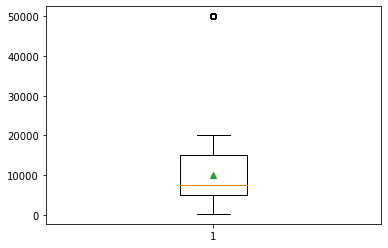

In [22]:
plt.boxplot(creditLimit['creditLimit'], widths=0.2, showmeans=True)
plt.show()

In [23]:
creditLimit['creditLimit'].describe()

count     5000.000000
mean     10149.150000
std      10816.765564
min        250.000000
25%       5000.000000
50%       7500.000000
75%      15000.000000
max      50000.000000
Name: creditLimit, dtype: float64

In [24]:
creditLimit[creditLimit['creditLimit']==50000].shape[0]

246

/Users/qiaozihui/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


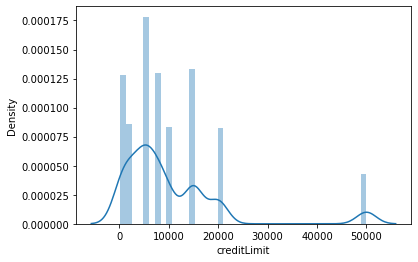

In [25]:
sns.distplot(creditLimit['creditLimit']);

#### Finding:

For all customers:

  •  Credit limits only have ten levels.

  •  the minimum credit limit is $250.
  
  •  the maximum credit limit is $50,000.
  
  •  the minority customer(246 customers) owns a credit limit of $50,000.
  
  •  credit limit mainly focus on 0-$20,000.

#### availableMoney

In [26]:
data_v0['availableMoney'].describe()

count    786363.000000
mean       6250.725369
std        8880.783989
min       -1005.630000
25%        1077.420000
50%        3184.860000
75%        7500.000000
max       50000.000000
Name: availableMoney, dtype: float64

/Users/qiaozihui/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


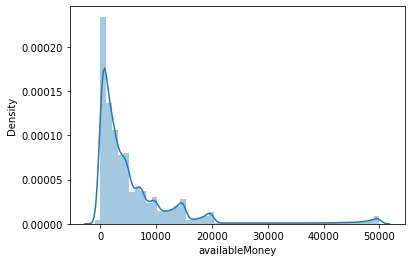

In [27]:
sns.distplot(data_v0['availableMoney']);

In [28]:
# The number of customers who exceeded their limit
data_v0[data_v0['availableMoney']<0]['accountNumber'].nunique()

428

#### Finding:

(1) right skewed

(2) This makes sense because you wouldn't find too many people with available funds that match their credit limit, as they may have already spent the money, and 428 customers have exceeded their limit in some transactions.

#### creditLimit and availableMoney

In [29]:
# according to the transactionDateTime and accountNumber make
# comparonsion of each customer's availableMoney and creditLimit
availableMoney = pd.DataFrame(data_v0.groupby(['accountNumber','transactionDateTime'])['availableMoney','creditLimit'].max())
availableMoney = availableMoney.sort_index(ascending=False)
availableMoney

/var/folders/9b/mzzkk68969n4702kpcrcv8b40000gn/T/ipykernel_12936/826962545.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  availableMoney = pd.DataFrame(data_v0.groupby(['accountNumber','transactionDateTime'])['availableMoney','creditLimit'].max())


availableMoney  creditLimit
accountNumber transactionDateTime                             
999389635     2016-12-24T05:19:30         4714.84         5000
              2016-11-24T00:21:46         4694.46         5000
              2016-10-23T16:47:41         4674.08         5000
              2016-09-22T13:58:30         4653.70         5000
              2016-09-16T15:35:24         4921.32         5000
...                                           ...          ...
100088067     2016-02-03T04:48:54        49933.93        50000
              2016-02-02T19:57:18        50000.00        50000
              2016-01-17T15:41:46        49748.44        50000
              2016-01-12T19:49:41        49794.87        50000
              2016-01-12T00:59:52        50000.00        50000

[786323 rows x 2 columns]

In [30]:
# selects the first row of each group to get the most recent availableMoney
# for each account number, compared to the creditLimit
most_recent_availableMoney = availableMoney.groupby('accountNumber').first()
most_recent_availableMoney

,availableMoney,creditLimit
accountNumber,,
100088067,49424.61,50000
100108752,4230.85,5000
100328049,4059.77,5000
100663626,14127.15,20000
100737756,119.23,250
...,...,...
999086814,3987.23,10000
999257059,12151.49,15000
999258704,4233.76,5000


In [31]:
# Get the number of customers who don't have 
# credit card overlimit or debt in the last record
most_recent_availableMoney[most_recent_availableMoney['availableMoney']==most_recent_availableMoney['creditLimit']].shape[0]

399

#### Finding:

399 customers don't have credit card overlimit or debt in the last reccent record

### 7. currentBalance Analysis

/Users/qiaozihui/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


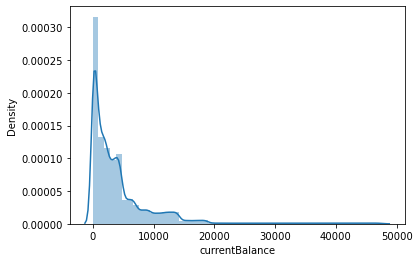

In [32]:
sns.distplot(data_v0['currentBalance']);

In [33]:
data_v0['currentBalance'].describe()

count    786363.000000
mean       4508.739089
std        6457.442068
min           0.000000
25%         689.910000
50%        2451.760000
75%        5291.095000
max       47498.810000
Name: currentBalance, dtype: float64

#### Finding:

(1) currentBalance is right skewed, show that a relatively small number of cardholders with very high balances, while most cardholders have lower balances.

(2) currentBalance shows Balance mean is 4508.739089, median is 2451.76, 

(3) There will be people who max out their credit limit, and no one has never used a credit card.

### 8. transactionDateTime

In [34]:
data_v0['transactionDateTime'].describe()

count                  786363
unique                 776637
top       2016-12-25T14:04:15
freq                        4
Name: transactionDateTime, dtype: object

In [35]:
# The first transaction in 2016
data_v0['transactionDateTime'].min()

'2016-01-01T00:01:02'

In [36]:
# The last transaction in 2016
data_v0['transactionDateTime'].max()

'2016-12-30T23:59:45'

#### Finding:

(1) The first transaction in 2016 was on 2016-01-01 00:01:02

(2) The last transaction in 2016 was on 2016-12-30 23:59:45

(3) There were 4 transactions that happened at the same time on 2016-12-25 14:04:15 (the maximum number of orders placed within the same second)

### 9. accountOpenDate and currentExpDate

#### accountOpenDate

In [37]:
data_v0['accountOpenDate'].describe()

count         786363
unique          1820
top       2014-06-21
freq           33623
Name: accountOpenDate, dtype: object

In [38]:
# The earliest accountOpenDate
data_v0['accountOpenDate'].min()

'1989-08-22'

In [39]:
# The latest accountOpenDate
data_v0['accountOpenDate'].max()

'2015-12-31'

#### Finding:

The majority of credit cards open date in 2014-06-21, with the earliest open date being 1989-08-22, and the latest open date being 2015-12-31.

#### currentExpDate

In [40]:
data_v0['currentExpDate'].describe()

count      786363
unique        165
top       03/2029
freq         5103
Name: currentExpDate, dtype: object

In [41]:
# The earliest ExpDate
data_v0['currentExpDate'].min()

'01/2020'

In [42]:
# The latest ExpDate
data_v0['currentExpDate'].max()

'12/2032'

#### Finding:

The majority of credit cards expire in 03/2029, with the earliest expiration date being 01/2020, and the latest expiration date being 12/2032.

### 10. dateOfLastAddressChange

In [43]:
# Top customer's last address change date
data_v0['dateOfLastAddressChange'].describe()

count         786363
unique          2184
top       2016-03-15
freq            3819
Name: dateOfLastAddressChange, dtype: object

In [44]:
# Customer's last address change date (Most recent)
data_v0['dateOfLastAddressChange'].max()

'2016-12-30'

In [45]:
# Customer's last address change date (Earliest)
data_v0['dateOfLastAddressChange'].min()

'1989-08-22'

In [46]:
# The number of customer never changed their Address
data_v0[data_v0['dateOfLastAddressChange']==data_v0['accountOpenDate']]['accountNumber'].nunique()

4986

In [47]:
data_v0.groupby('accountNumber')['dateOfLastAddressChange'].count().sort_values(ascending=False)

accountNumber
380680241    32850
882815134    13189
570884863    10867
246251253    10172
369308035     7229
             ...  
787335399        1
220057198        1
897071504        1
622138951        1
238928524        1
Name: dateOfLastAddressChange, Length: 5000, dtype: int64

#### Finding

(1) Interesting! Customer with accountNumber380680241 change address for 32850 times!

(2) 4986 customers never changed their address.

### 11. cardCVV and enteredCVV Analysis

#### cardCVV 

In [48]:
# The number of unique CVV number
data_v0['cardCVV'].nunique()

899

In [49]:
# cardCVV repeat information
data_v0['cardCVV'].value_counts()

869    33749
289    15509
640    10804
455    10279
959     7024
       ...  
653       33
825       29
183       28
125       23
566       19
Name: cardCVV, Length: 899, dtype: int64

#### Finding:

(1) We have 5,000 customers, but only 899 unique card CVV numbers, which means that there are different customers who use identical card CVV numbers. The most frequently used card CVV number is 869. 

(2) No one has their own unique CardCVV.

#### cardCVV and enteredCVV check

In [50]:
# The number of unique enteredCVV
data_v0['enteredCVV'].nunique()

976

#### Finding:

The number of unique EnteredCVV values is not equal to the number of unique CardCVV values, which means that some customers may have mistakenly input the wrong CVV number during transactions.

In [51]:
# The number of transactions which EnteredCVV is not equal to the real CardCVV
enteredCVV_cardCVV = (data_v0['enteredCVV'] == data_v0['cardCVV']).to_list()
dif_num = 0
enteredCVV_cardCVV
for i in enteredCVV_cardCVV:
    if i == False:
        dif_num += 1
print(dif_num)

7015


#### Finding:

7,015 transactions may mistakenly input the wrong CVV number.

In [52]:
# Checking transactions in which EnteredCVV is not equal to the real CardCVV may cause transaction failure
data_v0[data_v0['enteredCVV'] != data_v0['cardCVV']].head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
19,574788567,574788567,2500,2304.46,2016-01-29T07:33:15,196.07,Shell Auto Body,US,US,09,...,2015-10-13,2015-10-13,579,539,4219,PURCHASE,195.54,True,False,False
100,924729945,924729945,50000,50000.00,2016-10-04T04:20:04,168.57,discount.com,US,US,05,...,2014-07-25,2014-07-25,205,265,9459,PURCHASE,0.00,False,False,False
101,924729945,924729945,50000,49831.43,2016-10-19T14:01:45,168.57,discount.com,US,US,05,...,2014-07-25,2014-07-25,205,265,9459,REVERSAL,168.57,False,False,False
211,984504651,984504651,50000,35211.58,2016-02-16T18:41:33,296.68,WSC #467811,US,US,05,...,2015-07-27,2015-07-27,640,670,8332,PURCHASE,14788.42,False,False,False
261,984504651,984504651,50000,27469.74,2016-03-12T00:26:54,670.23,Walgreens #853025,US,US,09,...,2015-07-27,2015-07-27,640,240,8332,PURCHASE,22530.26,False,False,False


### 12. cardLast4Digits Analysis

In [53]:
data_v0['cardLast4Digits'].value_counts()

593     32946
2194    10867
6002    10172
6580     6747
8502     6553
        ...  
3462        1
7127        1
501         1
9907        1
1803        1
Name: cardLast4Digits, Length: 5245, dtype: int64

In [54]:
# The number of unique cardLast4Digits
data_v0['cardLast4Digits'].value_counts().shape[0]

5245

In [55]:
# Find the cardLast4Digits with the highest frequency
data_v0['cardLast4Digits'].mode()

0    593
Name: cardLast4Digits, dtype: int64

In [56]:
# The number of customer who has their own unique cardLast4Digits
c_i = (data_v0['cardLast4Digits'].value_counts() == 1).to_list()
c_i_num = 0
for i in c_i:
    if i == True:
        c_i_num += 1
print(c_i_num, "customers have their own unique cardLast4Digits")

77 customers have their own unique cardLast4Digits


#### Finding:

(1) 593 is the cardLast4Digits with the highest frequency.

(2) 77 customers have their own unique cardLast4Digits.

### 13. merchantName merchantCategoryCode merchantCountryCode Analysis
##### Attention: merchantCountryCode has null value

In [57]:
data_v0[['merchantName','merchantCategoryCode','merchantCountryCode']]

,merchantName,merchantCategoryCode,merchantCountryCode
0,Uber,rideshare,US
1,AMC #191138,entertainment,US
2,Play Store,mobileapps,US
3,Play Store,mobileapps,US
4,Tim Hortons #947751,fastfood,US
...,...,...,...
786358,Lyft,rideshare,US
786359,hulu.com,online_subscriptions,US
786360,Lyft,rideshare,US
786361,walmart.com,online_retail,US


In [58]:
# The number of merchants involved in the transactions
data_v0['merchantName'].nunique()

2490

In [59]:
# Top10 merchants based on transaction volume 
data_v0['merchantName'].value_counts()[:11]

Uber             25613
Lyft             25523
oldnavy.com      16992
staples.com      16980
alibaba.com      16959
apple.com        16898
walmart.com      16873
cheapfast.com    16858
ebay.com         16842
target.com       16813
amazon.com       16780
Name: merchantName, dtype: int64

In [60]:
# Country Information for Transactions
data_v0['merchantCountryCode'].value_counts()

US     778511
MEX      3143
CAN      2426
PR       1559
Name: merchantCountryCode, dtype: int64

#### merchantCountryCode null value fill in
##### I will check the merchantName of transactions with null values for merchantCountryCode, and use the merchantName with the most frequently occurring merchantCountryCode as the value to fill in, if not, using mode 'US' to fill in.

In [61]:
#for index,c in data_v0[data_v0['merchantCountryCode'].isnull()]['merchantName'].iteritems():
#    if c in data_v0['merchantName'].value_counts().index:
#        data_v0.loc[index,c] = data_v0[data_v0['merchantName']==c]['merchantCountryCode'].value_counts().index[0]
#    else:
#        data_v0.loc[index,c] = 'US'

It runs for a long time, If I have more time, I will do this. Now, I change my method to fill null value as mode value "US".It runs for a long time, If I have more time, I will do this. Now, I change my method to fill null value as mode value "US".

In [62]:
data_v0['merchantCountryCode'] = data_v0['merchantCountryCode'].fillna(value='US')
data_v0['merchantCountryCode'].value_counts()

US     779235
MEX      3143
CAN      2426
PR       1559
Name: merchantCountryCode, dtype: int64

In [63]:
# Mechants Type Information for Transactions
data_v0['merchantCategoryCode'].value_counts()

online_retail           202156
fastfood                112138
entertainment            80098
food                     75490
online_gifts             66238
rideshare                51136
hotels                   34097
fuel                     23910
subscriptions            22901
auto                     21651
health                   19092
personal care            18964
airline                  15412
mobileapps               14990
online_subscriptions     11067
furniture                 7432
food_delivery             6000
gym                       2209
cable/phone               1382
Name: merchantCategoryCode, dtype: int64

In [64]:
# Top1 
data_v0[data_v0['merchantName']=='Uber']['merchantCategoryCode'].iloc[0]

'rideshare'

In [65]:
# Top2
data_v0[data_v0['merchantName']=='Lyft']['merchantCategoryCode'].iloc[0]

'rideshare'

In [66]:
# Top3
data_v0[data_v0['merchantName']=='staples.com']['merchantCategoryCode'].iloc[0]

'online_retail'

#### Finding:

(1) 2490 merchants involved in the transactions.

(2) Top10 merchants based on transaction volume (Uber, Lyft, oldnavy.com, staples.com, alibaba.com, apple.com, walmart.com  , cheapfast.com, ebay.com, target.com, amazon.com).

(3) Top10 merchants mainly focus on rideshare, online_retail.

(4) Merchants only come from four countries, with the majority taking place in the US.

### 14. acqCountry Analysis

In [67]:
data_v0['acqCountry'].unique()

array(['US', nan, 'CAN', 'MEX', 'PR'], dtype=object)

In [68]:
# The number of null values
data_v0['acqCountry'].isnull().sum()

4562

In [69]:
# The number of transactions in each country
data_v0['acqCountry'].value_counts()

US     774709
MEX      3130
CAN      2424
PR       1538
Name: acqCountry, dtype: int64

#### Finding:

(1) Transactions only happened in four countries, with the majority taking place in the US, with the majority taking place in the PR.

(2) acqCountry has 4562 null values. 

### 15. posEntryMode and posConditionCode Analysis
##### Attention: posEntryMode and posConditionCode both have null value

##### posEntryMode

In [70]:
data_v0['posEntryMode'].unique()

array(['02', '09', '05', '80', '90', nan], dtype=object)

In [71]:
data_v0['posEntryMode'].isnull().sum()

4054

In [72]:
data_v0['posEntryMode'].value_counts()

05    315035
09    236481
02    195934
90     19576
80     15283
Name: posEntryMode, dtype: int64

Finding:

(1) posEntryMode has 5 categories, with the majority taking place in the '05','09','02', with the majority taking place in the '90','80'.

(2) posEntryMode has 4054 null values. 



####  posEntryMode null value fill in

The POS entry mode is usually determined by the type of terminal or point of sale system being used. I will use the mode "05" to fill in the null value.

If I have more time,  I will check the merchantName of transactions with null values for posEntryMode, and use the merchantName with the most frequently occurring posEntryMode as the value to fill in. It will run for a long time. Now, I will fill null value as mode value "05".

In [73]:
data_v0['posEntryMode'] = data_v0['posEntryMode'].fillna('05')
data_v0['posEntryMode'].value_counts()

05    319089
09    236481
02    195934
90     19576
80     15283
Name: posEntryMode, dtype: int64

##### posConditionCode

In [74]:
data_v0['posConditionCode'].unique()

array(['01', '08', '99', nan], dtype=object)

In [75]:
data_v0['posConditionCode'].isnull().sum()

409

In [76]:
data_v0['posConditionCode'].value_counts()

01    628787
08    149634
99      7533
Name: posConditionCode, dtype: int64

#### Finding:

(1) posConditionCode has 3 categories, with the majority taking place in the '01', with the minority taking place in the '99'.

(2) posConditionCode has 409 null values. 

####  posConditionCode null value fill in

I will fill null value as mode value "01".

In [77]:
data_v0['posConditionCode'] = data_v0['posConditionCode'].fillna('01')
data_v0['posConditionCode'].value_counts()

01    629196
08    149634
99      7533
Name: posConditionCode, dtype: int64

### 16. acqCountry
##### Attention: acqCountry has null values.

In [78]:
data_v0['acqCountry'].unique()

array(['US', nan, 'CAN', 'MEX', 'PR'], dtype=object)

In [79]:
data_v0['acqCountry'].isnull().sum()

4562

In [80]:
data_v0['acqCountry'].value_counts()

US     774709
MEX      3130
CAN      2424
PR       1538
Name: acqCountry, dtype: int64

#### Finding:

(1) acqCountry has 3 categories, with the majority taking place in the 'US', with the minority taking place in the 'PR'.

(2) acqCountry has 4562 null values. 

####  acqCountry null value fill in

I will fill null value as mode value "US".

In [81]:
data_v0['acqCountry'] = data_v0['acqCountry'].fillna('US')
data_v0['acqCountry'].value_counts()

US     779271
MEX      3130
CAN      2424
PR       1538
Name: acqCountry, dtype: int64

### 17. cardPresent

In [82]:
data_v0['cardPresent'].value_counts()

False    433495
True     352868
Name: cardPresent, dtype: int64

#### Finding:

(1) Out of all the transactions, 433,495 showed that the credit card was presented to a merchant, while 352,868 transactions did not involve the credit card being presented to a merchant. 

(2) Card present transactions are considered to be more secure than "card not present" transactions. Since the number of transactions where the credit card was not presented to a merchant is greater than those where it was presented, so it is essential to detect transaction fraud.

### 18. expirationDateKeyInMatch

In [83]:
data_v0['expirationDateKeyInMatch'].value_counts()

False    785320
True       1043
Name: expirationDateKeyInMatch, dtype: int64

In [84]:
# Top 10 accountNumber who has highest number of dismatch expiiration date transactions
data_v0[data_v0['expirationDateKeyInMatch']==True]['accountNumber'].value_counts()[:11]

882815134    35
570884863    33
785901398    24
246251253    23
139701939    11
225678947     9
474934734     9
325587097     8
208319653     8
832842201     8
802191006     8
Name: accountNumber, dtype: int64

#### Finding:

(1) When the expiration date entered during a transaction matches the expiration date on file for the credit card account, the transaction is considered an "ExpirationDateKeyInMatch" transaction. This indicates that the customer making the purchase likely has access to the physical credit card and is entering accurate information, which can help reduce the risk of fraud. Out of all the transactions, 1,043 showed that the entered expiration date did not match the expiration date associated with the credit card account. As a result, these 1,043 transactions were deemed to have a higher risk of fraud.

(2) There are Top 4 credit card accounts that have a higher risk of fraud because their expiration date information does not match during transactions relatively many times compared to other customers. The account numbers are listed as 882815134, 570884863, 785901398, and 246251253. 

### 19. isFraud

In [85]:
data_v0['isFraud'].value_counts()

False    773946
True      12417
Name: isFraud, dtype: int64

In [86]:
# Top 10 accountNumber who has highest number of fraud transactions
data_v0[data_v0['isFraud']==True]['accountNumber'].value_counts()[:11]

380680241    783
782081187    307
246251253    278
700725639    272
472288969    266
208319653    211
419709514    207
369308035    136
794398270    135
132629755    116
269616174    112
Name: accountNumber, dtype: int64

#### Finding:

The accountNumber 380680241 had the highest number of fraudulent transactions among all customers. The number of fraudulent transactions was shocking, with a total of 783 in one year (2016), which averages out to about 2 fraudulent transactions per day.

### Data Preprocessing Part 1 - Before Q2

Notice:

Before starting Question 2,

In the previous steps, I have cleared columns that had all null values and fill in null value for some columns.

I will create new timestamp features based on the 'transactionDateTime' column.

In [87]:
# make a copy
data = data_v0.copy() 

##### create new timestamp features - 'Date' and 'Time'

In [88]:
# create 'Date' column
data['Date'] = data_v0['transactionDateTime'].apply(lambda x: x.split('T')[0])

# create 'Time' column
data['Time'] = data_v0['transactionDateTime'].apply(lambda x: x.split('T')[1]) 

data.Date = pd.to_datetime(data.Date)
data['Timestamp'] = pd.to_datetime(data.Date.astype(str)+' '+ data.Time.astype(str))
data.head(5)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,Date,Time,Timestamp
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,414,1803,PURCHASE,0.0,False,False,False,2016-08-13,14:27:32,2016-08-13 14:27:32
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,486,767,PURCHASE,0.0,True,False,False,2016-10-11,05:05:54,2016-10-11 05:05:54
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,486,767,PURCHASE,0.0,False,False,False,2016-11-08,09:18:39,2016-11-08 09:18:39
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,486,767,PURCHASE,0.0,False,False,False,2016-12-10,02:14:50,2016-12-10 02:14:50
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,885,3143,PURCHASE,0.0,True,False,False,2016-03-24,21:04:46,2016-03-24 21:04:46


In [89]:
# Dataset Dimension
m,n = data.shape
print('Now, Dataset Size is:', m, 'x',n )

Now, Dataset Size is: 786363 x 26


## Question 2 Plot

exploratory data analysis (EDA) and data visualization

### 1. Transaction Amounts Basic Information 

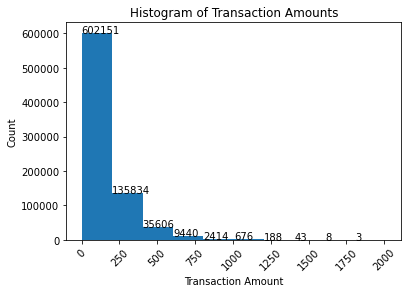

In [90]:
# Histogram of Transaction Amounts
counts, bins, _ = plt.hist(data['transactionAmount'])
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Histogram of Transaction Amounts')
plt.xticks(rotation=45)

for i in range(len(counts)):
    plt.text(bins[i], counts[i], str(int(counts[i])))

plt.show()

In [91]:
# Statistical information of transactionAmount
data['transactionAmount'].describe()

count    786363.000000
mean        136.985791
std         147.725569
min           0.000000
25%          33.650000
50%          87.900000
75%         191.480000
max        2011.540000
Name: transactionAmount, dtype: float64

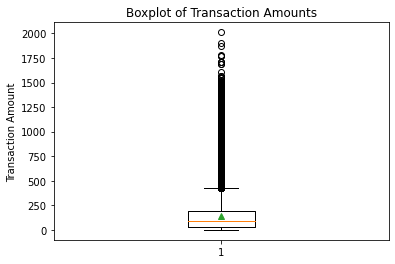

In [92]:
# boxplot of transactionAmount
plt.boxplot(data['transactionAmount'], widths=0.2, showmeans=True)
plt.ylabel('Transaction Amount')
plt.title('Boxplot of Transaction Amounts')
plt.show()

#### Finding:

(1) The dataset contains 786,363 transactions with a mean transaction amount of 136.99 dollars and a standard deviation of 147.73 dollars.

(2) The minimum transaction amount in the dataset is 0, while the maximum transaction amount is 2,011.54 dollars.

(3) Right-skewed distribution: the median transaction amount is 87.90 dollars, which is less than the mean, indicating that the distribution of transaction amounts is skewed to the right.

(4) 25% of the transactions have a transaction amount of 33.65 dollars or less, while 75% of the transactions have a transaction amount of 191.48 dollars or less. This suggests that the majority of transactions fall within this price range.

(5) The range of transaction amounts is quite wide, from 0 to over 2,000 dollars. This may indicate that the dataset includes a variety of different types of transactions, or that the transactions come from a variety of different sources.

(6) The standard deviation of transaction amounts is quite large, indicating that there is a lot of variability in the data. Through boxplot we can see there are many outliers. 

### 2. Relationship between Frauduent and transactionAmount

In [93]:
pd.DataFrame(data.groupby('isFraud')['transactionAmount'].agg([np.mean,np.median,np.std,np.max,np.min]))

,mean,median,std,amax,amin
isFraud,,,,,
False,135.570249,86.76,146.525305,2011.54,0.0
True,225.215905,176.98,189.551393,1608.35,0.0


#### Fraudulent Transaction Amounts

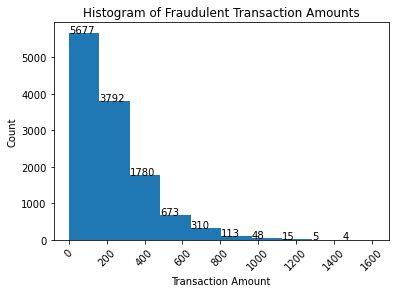

In [94]:
# Histogram of Fraudulent Transaction Amounts
counts, bins, _ = plt.hist(data[data['isFraud']==True]['transactionAmount'])
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Histogram of Fraudulent Transaction Amounts')
plt.xticks(rotation=45)

for i in range(len(counts)):
    plt.text(bins[i], counts[i], str(int(counts[i])))

plt.show()

In [95]:
# statistical information of fraudulent transaction amounts
data[data['isFraud']==True]['transactionAmount'].describe()

count    12417.000000
mean       225.215905
std        189.551393
min          0.000000
25%         86.000000
50%        176.980000
75%        311.460000
max       1608.350000
Name: transactionAmount, dtype: float64

#### Non-Fraudulent Transaction Amounts

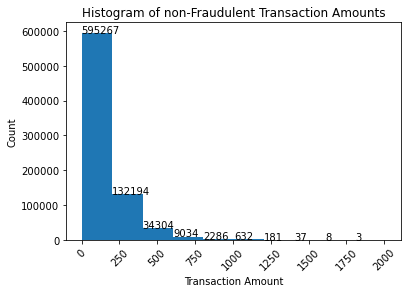

In [96]:
# Histogram of non-Fraudulent Transaction Amounts
counts, bins, _ = plt.hist(data[data['isFraud']==False]['transactionAmount'])
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Histogram of non-Fraudulent Transaction Amounts')
plt.xticks(rotation=45)

for i in range(len(counts)):
    plt.text(bins[i], counts[i], str(int(counts[i])))
    
plt.show()

In [97]:
# statistical information of non-fraudulent transaction amounts
data[data['isFraud']==False]['transactionAmount'].describe()

count    773946.000000
mean        135.570249
std         146.525305
min           0.000000
25%          33.190000
50%          86.760000
75%         189.390000
max        2011.540000
Name: transactionAmount, dtype: float64

#### Finding:

Based on the distribution of transaction amounts, I found that both fraudulent and non-fraudulent transactions have a right-skewed distribution, with a concentration of transactions between 0-400 dollars.

For fraudulent transactions, there is a decreasing trend in the number of transactions for amounts, with the largest transaction amount being 1608.35 dollars. 

For non-fraudulent transactions, I also observe a concentration of transactions between 0-400 dollars, and a decreasing trend in the number of transactions, with the largest transaction amount being 2011.54 dollars.

This finding is interesting as it suggests that fraudulent transactions are more likely to occur for smaller amounts, and the larger the transaction amount, the less likely it is to be a fraudulent transaction. This information could be useful for fraud detection and prevention, as it may be possible to develop targeted strategies for detecting and preventing fraudulent transactions based on transaction amounts.

### 3. Relationship between merchant categories and transactionAmount, also transactionCount

In [98]:
# Know relationship between merchant categories and transaction count
trans_mer_cat = pd.DataFrame(data.groupby('merchantCategoryCode')['transactionAmount'].count())
trans_mer_cat.columns = ['transaction_count']
trans_mer_cat = trans_mer_cat.sort_values('transaction_count',ascending=False)
trans_mer_cat.head()

,transaction_count
merchantCategoryCode,
online_retail,202156
fastfood,112138
entertainment,80098
food,75490
online_gifts,66238


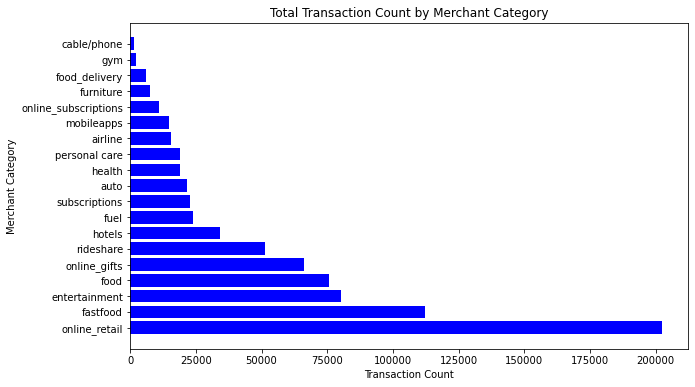

In [99]:
# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(trans_mer_cat.index, trans_mer_cat['transaction_count'], color='blue')
ax.set_xlabel('Transaction Count')
ax.set_ylabel('Merchant Category')
ax.set_title('Total Transaction Count by Merchant Category')
plt.show()

#### Top1 Merchant Category - Online Retail TransactionAmount Analysis

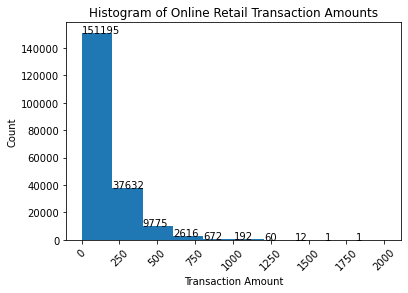

In [100]:
# Histogram of Online Retail Transaction Amounts
counts, bins, _ = plt.hist(data[data['merchantCategoryCode']=='online_retail']['transactionAmount'])
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Histogram of Online Retail Transaction Amounts')
plt.xticks(rotation=45)

for i in range(len(counts)):
    plt.text(bins[i], counts[i], str(int(counts[i])))

plt.show()

In [101]:
# Statistical information of Online Retail Transaction Amounts
data[data['merchantCategoryCode']=='online_retail']['transactionAmount'].describe()

count    202156.000000
mean        145.231632
std         150.212475
min           0.000000
25%          38.740000
50%          98.950000
75%         202.425000
max        2011.540000
Name: transactionAmount, dtype: float64

#### Median TransactionAmount for Merchant Category Analysis

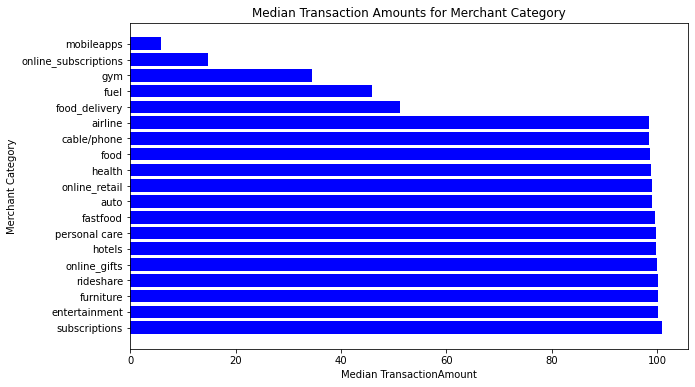

In [102]:
median_transactionAmount = pd.DataFrame(data.groupby('merchantCategoryCode')['transactionAmount'].median())
median_transactionAmount = median_transactionAmount.sort_values('transactionAmount', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(median_transactionAmount.index, median_transactionAmount['transactionAmount'], color='blue')
ax.set_xlabel('Median TransactionAmount')
ax.set_ylabel('Merchant Category')
ax.set_title('Median Transaction Amounts for Merchant Category')
plt.show()

#### Mean TransactionAmount for Merchant Category Analysis

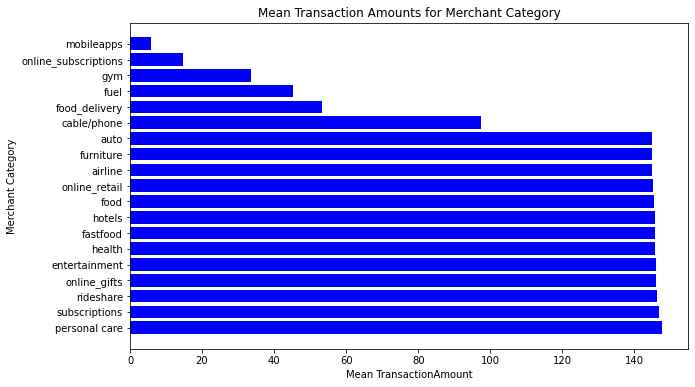

In [103]:
m_transactionAmount = pd.DataFrame(data.groupby('merchantCategoryCode')['transactionAmount'].mean())
m_transactionAmount = m_transactionAmount.sort_values('transactionAmount', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(m_transactionAmount.index, m_transactionAmount['transactionAmount'], color='blue')
ax.set_xlabel('Mean TransactionAmount')
ax.set_ylabel('Merchant Category')
ax.set_title('Mean Transaction Amounts for Merchant Category')
plt.show()

#### Finding:

Based on the median transaction amount for each merchant category, we can see that subscriptions have the highest median transaction amount, followed by entertainment and furniture. On the other hand, mobile apps, fuel, and gym have the lowest median transaction amounts.

Looking at the mean transaction amount for each merchant category, we see that personal care has the highest mean transaction amount, followed by subscriptions and rideshare. The lowest mean transaction amounts are seen in mobile apps, online subscriptions, and gym.

It's worth noting that the median and mean for each category has similar trend, but the median and mean values has gap, indicating that the distribution of transaction amounts for each category is skewed, same as the result of analysis I did before. 

### 4. Relationship between merchant categories and transactionAmount, transactionCount, isFraud or not

#### Fraud Transactions Rate by Merchant Category Analysis

In [104]:
# Fraud Transactions Rate by Merchant Category
merchantCategory_fraud = pd.DataFrame(data.groupby('merchantCategoryCode')['isFraud'].value_counts())
merchantCategory_fraud.columns = ['Count']
merchantCategory_fraud = merchantCategory_fraud.pivot_table(index='merchantCategoryCode', columns='isFraud', values='Count', aggfunc='sum')
merchantCategory_fraud = merchantCategory_fraud.replace(np.nan,0)
merchantCategory_fraud['fraud rate'] = merchantCategory_fraud.iloc[:,1]/(merchantCategory_fraud.iloc[:,0]+merchantCategory_fraud.iloc[:,1])
merchantCategory_fraud.sort_values('fraud rate', ascending=False)

isFraud,False,True,fraud rate
merchantCategoryCode,,,
airline,14878.0,534.0,0.034648
rideshare,49864.0,1272.0,0.024875
online_retail,197218.0,4938.0,0.024427
online_gifts,64632.0,1606.0,0.024246
furniture,7329.0,103.0,0.013859
food,74476.0,1014.0,0.013432
auto,21378.0,273.0,0.012609
entertainment,79137.0,961.0,0.011998
fastfood,111064.0,1074.0,0.009577


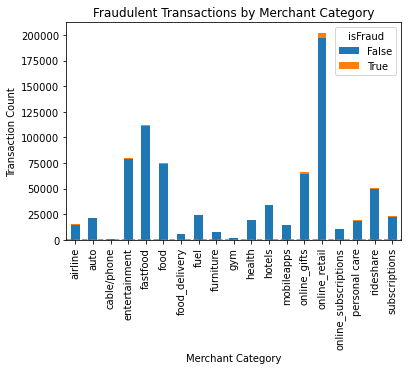

In [105]:
# Bar chart of Fraudulent Transactions by Merchant Category
merchantCategory_fraud.iloc[:,:2].plot(kind='bar', stacked=True)
plt.axhline(y=0.5, color='grey', linestyle='--')

plt.xlabel('Merchant Category')
plt.ylabel('Transaction Count')
plt.title('Fraudulent Transactions by Merchant Category')

plt.show()

#### Finding:

Looking at the table, I can see that the overall fraud rate is very low, ranging from 0.00% to 3.47%. Interestingly, some merchant categories have a zero fraud rate, which indicates that there are no fraudulent transactions in those categories.

For example, I see that the categories "mobileapps", "fuel", "food_delivery", "online_subscriptions", "cable/phone", and "gym" all have zero fraud rates. This suggests that transactions in these categories are less likely to be fraudulent, which can be helpful in identifying potentially risky transactions.

On the other hand, some categories have higher fraud rates, such as "airline", "rideshare", and "online_retail". This indicates that transactions in these categories may be more susceptible to fraudulent activity, and extra caution should be taken when processing transactions in these categories.

#### Median Transaction Amount and Fraud Rate by Merchant Category

In [106]:
# Median Transaction Amount and Fraud Rate by Merchant Category
mc_fr_median_amount = pd.merge(merchantCategory_fraud,
                               median_transactionAmount,
                               how = 'inner',
                               left_index = True,
                               right_index = True)
mc_fr_median_amount = mc_fr_median_amount.rename(columns={'transactionAmount': 'median_transactionAmount'})
mc_fr_median_amount = mc_fr_median_amount.sort_values('fraud rate',ascending=False)
mc_fr_median_amount

,False,True,fraud rate,median_transactionAmount
merchantCategoryCode,,,,
airline,14878.0,534.0,0.034648,98.460
rideshare,49864.0,1272.0,0.024875,100.080
online_retail,197218.0,4938.0,0.024427,98.950
online_gifts,64632.0,1606.0,0.024246,99.970
furniture,7329.0,103.0,0.013859,100.120
food,74476.0,1014.0,0.013432,98.680
auto,21378.0,273.0,0.012609,98.970
entertainment,79137.0,961.0,0.011998,100.120
fastfood,111064.0,1074.0,0.009577,99.485


#### Finding:

I can be observed that the fraud rate varies across different merchant categories. 

Interestingly, it can also be seen that the median transaction amount for merchant categories with relatively high fraud rates (such as airline and rideshare) is higher compared to those with low fraud rates (such as gym and online subscriptions). 

This suggests that there is a correlation between the median transaction amount and the likelihood of fraud in a particular merchant category.

## Question 3 
## Data Wrangling - Duplicate Transactions

### 1. First Assumption of duplicate transactions: reversal transaction


A reversed transaction in credit card transactions can seen as a chargeback. I think it occurs when a cardholder disputes a transaction and requests that the bank or card issuer reverse the charge and refund the amount back to their account.

And I believe there are various reasons why a cardholder may initiate a chargeback, including fraudulent transactions, goods or services not delivered or not as described, duplicate charges, unauthorized transactions, or errors in processing. So I think this type transactions can be seen as duplicate transactions.

##### Assumption 1 of reversal transaction:

I assume that purchase transactions and reversal transactions are successive, the same account number, same merchantName, the same transaction amount.   

Now, I will sort the datasets in ascending order based on several columns, including customerID, merchantName, and Timestamp, to identify purchase-reversal consecutive transactions that occur over time.

In [107]:
data_v1 = data.sort_values(by=['customerId','merchantName','Timestamp'],ascending=True)

# remove trsanctions whose transactionType is ADDRESS_VERIIFICATION and reset index
data_v1 = data_v1[(data_v1['transactionType']=='PURCHASE')|(data_v1['transactionType']=='REVERSAL')]
data_v1 = data_v1.reset_index(drop=True)
data_v1['dataindex'] = data_v1.index
data_v1.head(5)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,Date,Time,Timestamp,dataindex
0,100088067,100088067,50000,49953.81,2016-04-08T19:56:36,200.12,1st BBQ,US,US,09,...,4615,PURCHASE,46.19,True,False,False,2016-04-08,19:56:36,2016-04-08 19:56:36,0
1,100088067,100088067,50000,49929.31,2016-11-09T07:26:06,95.11,1st Pub,US,US,02,...,2077,PURCHASE,70.69,True,False,False,2016-11-09,07:26:06,2016-11-09 07:26:06,1
2,100088067,100088067,50000,49996.04,2016-05-06T02:54:01,5.26,1st Sandwitch Bar #758805,US,US,02,...,4615,PURCHASE,3.96,True,False,False,2016-05-06,02:54:01,2016-05-06 02:54:01,2
3,100088067,100088067,50000,49933.93,2016-02-03T04:48:54,141.60,34th BBQ #412895,US,US,09,...,4615,PURCHASE,66.07,True,False,False,2016-02-03,04:48:54,2016-02-03 04:48:54,3
4,100088067,100088067,50000,50000.00,2016-06-03T18:50:55,304.15,AMC #191138,US,US,02,...,4615,PURCHASE,0.00,True,False,False,2016-06-03,18:50:55,2016-06-03 18:50:55,4


In [108]:
# Get Reversal Transactions Index
reversal_index = data_v1[data_v1['transactionType'] == 'REVERSAL'].index.values.astype(int)

In [109]:
# Create Reversal Transactions DataFrame
reversal_df = data_v1.iloc[reversal_index]
reversal_df['reversal_index'] = reversal_index
reversal_df.head(2)

/var/folders/9b/mzzkk68969n4702kpcrcv8b40000gn/T/ipykernel_12936/1501163233.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reversal_df['reversal_index'] = reversal_index


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,Date,Time,Timestamp,dataindex,reversal_index
13,100088067,100088067,50000,49811.88,2016-11-20T08:00:04,22.32,AMC #79863,US,US,09,...,REVERSAL,188.12,True,False,False,2016-11-20,08:00:04,2016-11-20 08:00:04,13,13
124,100328049,100328049,5000,4605.10,2016-01-15T20:36:18,43.74,Lyft,US,US,09,...,REVERSAL,394.90,False,False,False,2016-01-15,20:36:18,2016-01-15 20:36:18,124,124


In [110]:
reversal_tra_num = reversal_df.shape[0]
print(f'There are {reversal_tra_num} reversal transactions in the all transactions')

There are 20303 reversal transactions in the all transactions


In [111]:
# Get consecutive index
prev_index_equal_purchase = reversal_index - 1

In [112]:
# Create consecutive transaction dataframe
purchase_df = data_v1.iloc[prev_index_equal_purchase]
purchase_df['purchase_index'] = prev_index_equal_purchase
purchase_df['transactionType'].value_counts()

/var/folders/9b/mzzkk68969n4702kpcrcv8b40000gn/T/ipykernel_12936/4010265600.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_df['purchase_index'] = prev_index_equal_purchase


PURCHASE    20109
REVERSAL      194
Name: transactionType, dtype: int64

##### Now, I know that purchase transactions and reversal transactions are not always consecutive. Once I finish analyzing consecutive purchase-reversal transactions, I will then analyze non-consecutive purchase-reversal transactions.

In [113]:
# Create only purchase transaction dataframe in the consecutive transactions
purchase_df = purchase_df[purchase_df['transactionType']=='PURCHASE']
purchase_df['reversal_index'] = purchase_df['purchase_index']+1
purchase_df.head(2)

/var/folders/9b/mzzkk68969n4702kpcrcv8b40000gn/T/ipykernel_12936/2779469278.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_df['reversal_index'] = purchase_df['purchase_index']+1


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,Date,Time,Timestamp,dataindex,purchase_index,reversal_index
12,100088067,100088067,50000,49834.20,2016-11-20T07:57:05,22.32,AMC #79863,US,US,09,...,165.80,True,False,False,2016-11-20,07:57:05,2016-11-20 07:57:05,12,12,13
123,100328049,100328049,5000,4648.84,2016-01-15T20:34:35,43.74,Lyft,US,US,09,...,351.16,False,False,False,2016-01-15,20:34:35,2016-01-15 20:34:35,123,123,124


In [114]:
# Merge purchase-reversal transactions to a dataframe with the same account number, same merchantName, the same transaction amount
merge_df = pd.merge(purchase_df, reversal_df, how = 'inner',
                    on = ['accountNumber', 'transactionAmount','merchantName','reversal_index'])
merge_df = merge_df[['accountNumber','transactionAmount','merchantName',
                     'Timestamp_x','transactionType_x','purchase_index',
                     'Timestamp_y','transactionType_y','reversal_index']]
merge_df.head(2)

,accountNumber,transactionAmount,merchantName,Timestamp_x,transactionType_x,purchase_index,Timestamp_y,transactionType_y,reversal_index
0,100088067,22.32,AMC #79863,2016-11-20 07:57:05,PURCHASE,12,2016-11-20 08:00:04,REVERSAL,13
1,100328049,43.74,Lyft,2016-01-15 20:34:35,PURCHASE,123,2016-01-15 20:36:18,REVERSAL,124


In [115]:
# Create consecutive purchase-reversal transaction dataframe
con_purchase_index = merge_df['purchase_index'].to_list()
con_reversal_index = merge_df['reversal_index'].to_list()
all_con_index = con_purchase_index + con_reversal_index
all_con_df = data_v1.iloc[all_con_index]
all_con_df.head(2)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,Date,Time,Timestamp,dataindex
12,100088067,100088067,50000,49834.20,2016-11-20T07:57:05,22.32,AMC #79863,US,US,09,...,4615,PURCHASE,165.80,True,False,False,2016-11-20,07:57:05,2016-11-20 07:57:05,12
123,100328049,100328049,5000,4648.84,2016-01-15T20:34:35,43.74,Lyft,US,US,09,...,2941,PURCHASE,351.16,False,False,False,2016-01-15,20:34:35,2016-01-15 20:34:35,123


In [116]:
# Get consecutive purchase-reversal transaction number
consecutive_reversal = merge_df.shape[0]
print(f'There are {consecutive_reversal} consecutive purchase-reversal transactions.(reversal)')

There are 12665 consecutive purchase-reversal transactions.(reversal)


In [117]:
# Get consecutive purchase-reversal transaction Amount
consecutive_transaction_amount = np.round(all_con_df['transactionAmount'].sum()/2,2)
print(f'The transactionAmount of consecutive reversal transactions is {consecutive_transaction_amount}.')

The transactionAmount of consecutive reversal transactions is 1907433.62.


##### Assumption 2 of reversal transaction

There are purchase transactions and reversal transactions are not successive, but they have the same account number, same merchantName, the same transaction amount. Also, purchase was ealier than reversal.

In [118]:
# Calculate non consecutive reversal transactions number
non_consecutive_reversal = reversal_df.shape[0] - merge_df.shape[0]
print(f'Except consecutive reversal transactions, there are {non_consecutive_reversal} left. ')

Except consecutive reversal transactions, there are 7638 left. 


In [119]:
# Get exclude consecutive reversal transactions dataframe
reversal_df_nc = reversal_df.drop(con_reversal_index)
reversal_df_nc.head(2)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,Date,Time,Timestamp,dataindex,reversal_index
538,101376441,101376441,7500,7500.00,2016-08-06T17:23:47,0.0,cheapfast.com,US,US,09,...,REVERSAL,0.00,False,False,False,2016-08-06,17:23:47,2016-08-06 17:23:47,538,538
596,101380713,101380713,10000,725.69,2016-12-13T17:22:58,0.0,Lyft,MEX,MEX,02,...,REVERSAL,9274.31,False,False,False,2016-12-13,17:22:58,2016-12-13 17:22:58,596,596


In [120]:
# Get exclude consecutive purchase transactions dataframe
purchase_all_df = data_v1[data_v1['transactionType']=='PURCHASE']
purchase_all_df['purchase_index'] = purchase_all_df.index
purchase_df_nc = purchase_all_df.drop(con_purchase_index)
purchase_df_nc.head(2)

/var/folders/9b/mzzkk68969n4702kpcrcv8b40000gn/T/ipykernel_12936/2891271026.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_all_df['purchase_index'] = purchase_all_df.index


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,Date,Time,Timestamp,dataindex,purchase_index
0,100088067,100088067,50000,49953.81,2016-04-08T19:56:36,200.12,1st BBQ,US,US,09,...,PURCHASE,46.19,True,False,False,2016-04-08,19:56:36,2016-04-08 19:56:36,0,0
1,100088067,100088067,50000,49929.31,2016-11-09T07:26:06,95.11,1st Pub,US,US,02,...,PURCHASE,70.69,True,False,False,2016-11-09,07:26:06,2016-11-09 07:26:06,1,1


In [121]:
# Create non-consecutive transactions to a dataframe with the same account number, same merchantName, the same transaction amount
merge_nc_df = pd.merge(purchase_df_nc, reversal_df_nc, how = 'inner',
                       on = ['accountNumber', 'transactionAmount','merchantName'])
merge_nc_df = merge_nc_df[(merge_nc_df['Timestamp_x']<=merge_nc_df['Timestamp_y'])]
merge_nc_df = merge_nc_df[['accountNumber','transactionAmount','merchantName',
                          'Timestamp_x','transactionType_x','purchase_index',
                          'Timestamp_y','transactionType_y','reversal_index']]
merge_nc_df.head(2)

,accountNumber,transactionAmount,merchantName,Timestamp_x,transactionType_x,purchase_index,Timestamp_y,transactionType_y,reversal_index
0,101738384,174.92,discount.com,2016-03-03 19:51:21,PURCHASE,1045,2016-03-17 05:37:44,REVERSAL,1047
1,101738384,954.71,staples.com,2016-05-26 07:14:32,PURCHASE,1158,2016-06-11 00:47:21,REVERSAL,1161


###### check if there have been multiple matching transactions for reversal requests

In [122]:
merge_nc_df['reversal_index'].nunique()

5112

In [123]:
merge_nc_df['purchase_index'].nunique()

5216

In [124]:
merge_nc_df.shape[0]

5219

Yes, there have been multiple matching transactions for reversal requests that I am not able to explain. I need to find these transactions.

In [125]:
# Delete multiple match reversal transactions 
unable_purchase_index = list((merge_nc_df['purchase_index'].value_counts()>1).index[:3])
need_eliminate_index = list(merge_nc_df[merge_nc_df['purchase_index'].isin(unable_purchase_index)].index)
merge_nc_df = merge_nc_df.drop(need_eliminate_index)

In [126]:
unable_reversal_index = merge_nc_df['reversal_index'].value_counts()>1
unable_reversal_index = list(unable_reversal_index[unable_reversal_index==True].index)
need_eliminate_index_2 = list(merge_nc_df[merge_nc_df['reversal_index'].isin(unable_reversal_index)].index)
merge_nc_df = merge_nc_df.drop(need_eliminate_index_2)

In [127]:
# Be able to explain non-consecutive reversal transactions number
print('Be able to explain non-consecutive reversal transactions number:', merge_nc_df.shape[0])

Be able to explain non-consecutive reversal transactions number: 5013


In [128]:
nc_reversal_index = merge_nc_df['reversal_index'].to_list()
nc_purchase_index = merge_nc_df['purchase_index'].to_list()
all_nc_index = nc_reversal_index + nc_purchase_index
all_nc_df = data_v1.iloc[all_nc_index]
all_nc_df.head(2)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,Date,Time,Timestamp,dataindex
1047,101738384,101738384,50000,38753.10,2016-03-17T05:37:44,174.92,discount.com,US,US,05,...,4704,REVERSAL,11246.90,False,False,False,2016-03-17,05:37:44,2016-03-17 05:37:44,1047
1161,101738384,101738384,50000,26739.32,2016-06-11T00:47:21,954.71,staples.com,US,US,02,...,4704,REVERSAL,23260.68,False,False,False,2016-06-11,00:47:21,2016-06-11 00:47:21,1161


In [129]:
# The number of reversal transactions belongs to non-successive purchase-reversal transactions
non_consecutive_reversal_true = merge_nc_df.shape[0]
print('The number of reversal transactions belongs to non-successive purchase-reversal transactions:', non_consecutive_reversal_true)

The number of reversal transactions belongs to non-successive purchase-reversal transactions: 5013


In [130]:
# Get non-consecutive purchase-reversal transaction Amount
non_consecutive_transaction_amount = np.round(all_nc_df['transactionAmount'].sum()/2,2)
print(f'The transactionAmount of non-consecutive reversal transactions is {non_consecutive_transaction_amount}.')

The transactionAmount of non-consecutive reversal transactions is 747915.74.


In [131]:
# Concat consecutive and non-consecutive transactions in one dataframe
able_expl_df = pd.concat([all_con_df,all_nc_df],axis=0)
able_expl_df.shape

(35356, 27)

In [132]:
# Able to explain reversal transactions' number
able_expl_df['transactionType'].value_counts()

PURCHASE    17678
REVERSAL    17678
Name: transactionType, dtype: int64

In [133]:
# Able to explain reversal transactions' amount
able_expl_df.groupby(['transactionType']).sum()['transactionAmount']

transactionType
PURCHASE    2655349.36
REVERSAL    2655349.36
Name: transactionAmount, dtype: float64

In [134]:
# Not able to explain reversal transactions' amount
reversal_df_all = data_v1[data_v1['transactionType']=='REVERSAL']
able_expl = con_reversal_index + nc_reversal_index
not_able_expl_df = reversal_df_all.drop(able_expl,axis=0)
not_able_expl_amount = not_able_expl_df['transactionAmount'].sum()
print('Not able to explain reversal transactions amount', not_able_expl_amount)

Not able to explain reversal transactions amount 166443.14


In [135]:
# Not able to match reversal transactions number
reversal_many_times = non_consecutive_reversal - non_consecutive_reversal_true
print(f'There was not able to match {reversal_many_times} reversal transactions.')

There was not able to match 2625 reversal transactions.


##### Assumption 3 of reversal transaction

##### Lessons Learned

I was not able to match 2526 reversal transactions.

Now, I think there are three additional situations involving reversal transactions:

(1) The same purchase transaction being reversed multiple times

(2) The reversal amount not matching the purchase amount

(3) Data quality.

 

### Question 3 part a - identify reversed reversed transactions result

What total number of transactions and total dollar amount do you estimate for the reversed transactions?

Result 1: As a result of my analysis, I found 17678 reversal transactions and total dollar value of these are $2,655,349.36

Result 2: I was not able to find purchase associated to reversal transactions (2625) that corresponds to $166,443.14.

### Remove Duplicates (Reversal Transactions)

In [136]:
data_v2 = data_v1.drop(list(able_expl_df.index))

In [137]:
data_v2 = data_v2[data_v2['transactionType']!='REVERSAL']

In [138]:
data_v2 = data_v2.reset_index()

In [139]:
data_v2['dataindex'] = data_v2.index

### 2. Second Assumption of duplicate transactions: multi-swipe transactions

##### Assumption of multi-swipe transactions:

I assume that multiple credit card transactions occur in the data as follows: a customer makes multiple credit card transactions with the same amount within 5 minutes at the same merchant location. 

##### Method :

To sort the data by 'accountNumber', 'merchantName', 'Timestamp', and 'transactionAmount' in ascending order to ensure the accurate match of customer and merchant transaction time difference column. Then, select all transactions with time differences within 5 minutes, group by 'accountNumber', 'merchantName', and 'transactionAmount', and filter out all transactions where a customer makes more than one transaction with the same amount at the same merchant within 5 minutes. I define these transactions as multiple credit card transactions.

In [140]:
# Create a copy datset
data_v3 = data_v2.copy()[['accountNumber','transactionAmount','merchantName','transactionType', 'Timestamp','dataindex']]

In [141]:
# To get the accurate match of customer and merchant transaction time difference column
data_v3 = data_v3.sort_values(['accountNumber','merchantName', 'transactionAmount','Timestamp',])
data_v3['diff'] = data_v3['Timestamp'].diff().dt.total_seconds() / 60

# Assume 5 minutes as multi-swipe time range
data_v3 = data_v3[data_v3['diff']<=5]

# Select all transactions with time differences within 5 minutes
duplicated = data_v3.groupby(['accountNumber','merchantName','transactionAmount'])['diff'].count()>1

# Filter out all transactions where a customer makes more than one transaction
data_v3_3index = data_v3.set_index(['accountNumber','merchantName','transactionAmount'])
data_v3_3index = data_v3_3index[duplicated]
data_v3_3index.head(5)

/var/folders/9b/mzzkk68969n4702kpcrcv8b40000gn/T/ipykernel_12936/2890327176.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_v3_3index = data_v3_3index[duplicated]


transactionType  \
accountNumber merchantName     transactionAmount                   
100737756     34th BBQ #166379 43.25                    PURCHASE   
                               43.25                    PURCHASE   
              Franks Deli      693.50                   PURCHASE   
                               693.50                   PURCHASE   
                               693.50                   PURCHASE   

                                                           Timestamp  \
accountNumber merchantName     transactionAmount                       
100737756     34th BBQ #166379 43.25             2016-07-10 14:31:07   
                               43.25             2016-07-10 14:32:06   
              Franks Deli      693.50            2016-01-18 01:55:24   
                               693.50            2016-01-18 01:55:28   
                               693.50            2016-01-18 01:58:26   

                                                  dataindex           diff  
accountNumber merchantName     transactionAmount                            
100737756     34th BBQ #166379 43.25                    247 -198000.516667  
                               43.25                    248       0.983333  
              Franks Deli      693.50                   311 -202893.200000  
                               693.50                   312       0.066667  
                               693.50                   313       2.966667

Since I consider the first transaction as "normal", I exclude its index from the list of indices for multi-swipe transactions.

In [142]:
# Get native index of multi-swipe transactions
grouped = data_v3_3index.groupby(['accountNumber', 'merchantName', 'transactionAmount'])
dataindexes = grouped['dataindex'].apply(lambda x: x.iloc[1:]).tolist()

##### The number of multi-swipe transactions

In [143]:
len_multi = len(dataindexes)
print(f'Excluding the first transaction which is considered as a normal transaction, there are a total of {len_multi} multi-swipe transactions.')

Excluding the first transaction which is considered as a normal transaction, there are a total of 4056 multi-swipe transactions.


##### The amount of multi-swipe transactions

In [144]:
amount = data_v2[data_v2['dataindex'].isin(dataindexes)]['transactionAmount'].sum()
print(f'Excluding the first transaction which is considered as a normal transaction, there are a total amount of $ {amount} multi-swipe transactions.')

Excluding the first transaction which is considered as a normal transaction, there are a total amount of $ 594370.01 multi-swipe transactions.


##### Swipe Time Range Analysis

In [145]:
# Minimum swipe time for multi-swipe transactions
min_swipe = data_v3_3index[data_v3_3index['diff']>0]['diff'].min() * 60
print('Minimum swipe time for multi-swipe transactions:' ,min_swipe, 'seconds')

Minimum swipe time for multi-swipe transactions: 1.0 seconds


In [146]:
# Maximum swipe time for multi-swipe transactions
max_swipe = np.round(data_v3_3index[data_v3_3index['diff']>0]['diff'].max(),1)
print('Maximum swipe time for multi-swipe transactions:' ,max_swipe, 'minutes')

Maximum swipe time for multi-swipe transactions: 4.9 minutes


In [147]:
# Average swipe time for multi-swipe transactions
mean_swipe = np.round(data_v3_3index[data_v3_3index['diff']>0]['diff'].mean(),2)
print('Mean swipe time for multi-swipe transactions:' ,mean_swipe, 'minutes')

Mean swipe time for multi-swipe transactions: 1.52 minutes


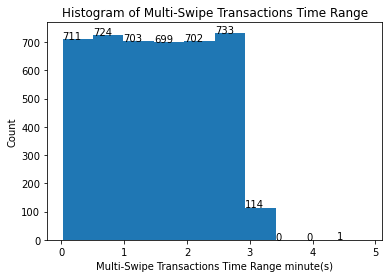

In [148]:
# Histogram of Multi-Swipe Transactions Time Range
counts, bins, _ = plt.hist(data_v3_3index[data_v3_3index['diff']>0]['diff'])
plt.xlabel('Multi-Swipe Transactions Time Range minute(s)')
plt.ylabel('Count')
plt.title('Histogram of Multi-Swipe Transactions Time Range')

for i in range(len(counts)):
    plt.text(bins[i], counts[i], str(int(counts[i])))

plt.show()

In [149]:
# Multi-swipe transactions times(frequency)
times_swipe = data_v3.groupby(['accountNumber','merchantName','transactionAmount'])['diff'].count().value_counts()
times_swipe

1    342543
2      3376
3       340
Name: diff, dtype: int64

#### Finding:

(1) Multi-swipe transactions are mainly concentrated within 0-3.5 minutes of card-swiping time.

(2) Multi-swipe transactions are mostly concentrated within 2 card-swipes.

### Question 3 part b - identify multi-swipe transactions result

What total number of transactions and total dollar amount do you estimate for the multi-swipe transactions?

Result 1: As a result of my analysis, total number of multi-swipe transactions is 4056 based on 5 minutes time range.

Result 2: Total dollar value of multi-swipe transactions is $ 594,370.

### Remove Duplicates (Multi-Swipe Transactions)

In [150]:
data_v4 = data_v2.drop(dataindexes)

In [151]:
data_v4 = data_v4.reset_index()

In [152]:
data_v4['dataindex'] = data_v4.index

In [153]:
duplicats_rate = np.round((17678 + 4056)/data_v0.shape[0]*100,2)
print(f'Both reversal and multi-swipes transactions that I can detect that corresponds to {duplicats_rate}% of original data.')

Both reversal and multi-swipes transactions that I can detect that corresponds to 2.76% of original data.


### Question 3 part c 

Did you find anything interesting about either kind of transaction?

Yeah! Sure! 

For reversal transactions, I was not able to match 2526 reversal transactions. I think there are three additional situations involving reversal transactions:

(1) The same purchase transaction being reversed multiple times

(2) The reversal amount not matching the purchase amount

(3) Data quality.

For Multi-swipe transactions, I assume that multiple credit card transactions occur in when a customer makes multiple credit card transactions with the same amount within 5 minutes at the same merchant location. And I found that multi-swipe times(freequency) was not too many, mostly concentrated within 2 card-swipes.

(1) Multi-swipe transactions are mainly concentrated within 0-3.5 minutes of card-swiping time.

(2) Multi-swipe transactions are mostly concentrated within 2 card-swipes.

I found 21734 observations as duplicates (combination of both reversal and multi-swipes) that corresponds to 2.76% of original data.

## Question 4 
## Modeling - Fraud Detection

In [154]:
# Organize the dataset
df_temp = data_v0.copy()
df_temp['Date'] = df_temp['transactionDateTime'].apply(lambda x: x.split('T')[0])
df_temp['Time'] = df_temp['transactionDateTime'].apply(lambda x: x.split('T')[1]) 
df_temp.Date = pd.to_datetime(df_temp.Date)
df_temp['Timestamp'] = pd.to_datetime(df_temp.Date.astype(str)+' '+ df_temp.Time.astype(str))
df_temp = df_temp[df_temp['transactionType']=='ADDRESS_VERIFICATION']

data_v4 = pd.concat([data_v4,df_temp],axis=0)
data_v4 = data_v4.iloc[:,2:]

In [155]:
data_v4.shape

(744326, 27)

### Delete non-relevant columns

Based on the exploratory data analysis I conducted, I found that 'accountNumber' and 'customerId' have a one-to-one correspondence, so I decided to keep 'customerId' and eliminate 'accountNumber'. Additionally, I created a new feature called 'Timestamp', which made 'transactionDateTime' redundant, so I removed that column as well. Since the focus of the model is on fraud detection and not the account history or longevity, I eliminated 'currentExpDate' and 'accountOpenDate'. Lastly, 'cardLast4Digits' was not found to be relevant to the model, so I also eliminated that column.

In [156]:
data_v4 = data_v4.drop(['accountNumber','transactionDateTime','currentExpDate','accountOpenDate',
                        'cardLast4Digits','Date','Time','dataindex'],axis=1)

In [157]:
data_v4 = data_v4.drop(['dateOfLastAddressChange','cardCVV','enteredCVV'],axis=1)

In [158]:
data_v4 = data_v4.drop(['acqCountry','merchantCountryCode'],axis=1)

In [159]:
data_v4.columns

Index(['customerId', 'creditLimit', 'availableMoney', 'transactionAmount',
       'merchantName', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'transactionType', 'currentBalance',
       'cardPresent', 'expirationDateKeyInMatch', 'isFraud', 'Timestamp'],
      dtype='object')

In [160]:
# Put 'isFraud' to the last column
data_v4 = data_v4[['customerId', 'creditLimit', 'availableMoney', 'transactionAmount',
                   'merchantName','posEntryMode','posConditionCode', 'merchantCategoryCode', 
                   'transactionType','currentBalance', 'cardPresent', 'expirationDateKeyInMatch',
                   'Timestamp','isFraud']]

In [161]:
data_v4.head(5)

,customerId,creditLimit,availableMoney,transactionAmount,merchantName,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,Timestamp,isFraud
0,100088067,50000,49953.81,200.12,1st BBQ,09,01,food,PURCHASE,46.19,True,False,2016-04-08 19:56:36,False
1,100088067,50000,49929.31,95.11,1st Pub,02,01,food,PURCHASE,70.69,True,False,2016-11-09 07:26:06,False
2,100088067,50000,49996.04,5.26,1st Sandwitch Bar #758805,02,01,food,PURCHASE,3.96,True,False,2016-05-06 02:54:01,False
3,100088067,50000,49933.93,141.60,34th BBQ #412895,09,08,food,PURCHASE,66.07,True,False,2016-02-03 04:48:54,False
4,100088067,50000,50000.00,304.15,AMC #191138,02,01,entertainment,PURCHASE,0.00,True,False,2016-06-03 18:50:55,False


### Data Imbalance Degree Check 

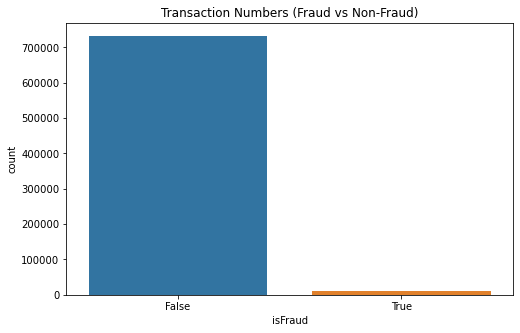

In [162]:
# Transaction Numbers (Fraud vs Non-Fraud)
plt.figure(figsize=(8,5))
sns.countplot(data=data_v4, x='isFraud')
plt.title('Transaction Numbers (Fraud vs Non-Fraud)')
plt.show()

#### This dataset is severely imbalanced, so I have decided to perform sampling in order to address the imbalance.

### Sampling

I am planning to use an undersampling technique in which I keep all fraud cases in the dataset. I then draw a sample (with a ratio of 0.1) from the non-fraudulent transactions of the same customer, which helps the model learn the regular patterns of that customer. Finally, to increase the model's generalization ability and improve its ability to handle noise, I also take samples from customers who have not encountered any fraud cases.

In [163]:
# Get all fraud transactions
data_f = data_v4[data_v4['isFraud']==True] 

# There are 11717 fraud transactions
data_f.shape[0]

11717

In [164]:
# 2040 unique customer have encountered fraudulent transactions
data_f['customerId'].nunique()

2043

In [165]:
# Get all non-fraud transactions
data_n_f = data_v4[data_v4['isFraud']==False] 

In [166]:
# Get non-fraud transactions of 2043 customers
c_fraud_list=data_f['customerId'].unique().tolist() 
data_f_new = data_n_f[data_n_f['customerId'].isin(c_fraud_list)] 

In [167]:
# Random choose 10% non-fraud transactions from 2043 customers
df_n = data_f_new.sample(frac=0.1, random_state=666)  

In [168]:
# Random choose 2% non-fraud transactions from dataset
df_noise = data_n_f.sample(frac=0.02, random_state=666)

In [169]:
# merge dataframes and delete duplicates
df_final = pd.concat([data_f,df_n,df_noise], axis=0) 
df_final = df_final.drop_duplicates()
df_final['isFraud'].value_counts()

False    73754
True     11717
Name: isFraud, dtype: int64

In [170]:
# Ratio of fraud transactions
np.round(11717/(73754+11717),2)

0.14

### Feature Engineering

In [171]:
df_final.head(3)

,customerId,creditLimit,availableMoney,transactionAmount,merchantName,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,Timestamp,isFraud
70,100088067,50000,49734.57,309.96,South Cafe,05,01,food,PURCHASE,265.43,True,False,2016-12-26 19:14:46,True
248,100737756,250,52.70,331.72,34th BBQ #166379,90,01,food,PURCHASE,197.30,True,False,2016-11-05 17:50:30,True
439,101132326,1000,815.86,118.36,South Steakhouse #157238,09,01,food,PURCHASE,184.14,True,False,2016-10-25 09:45:49,True


In [172]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85471 entries, 70 to 35530
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customerId                85471 non-null  int64         
 1   creditLimit               85471 non-null  int64         
 2   availableMoney            85471 non-null  float64       
 3   transactionAmount         85471 non-null  float64       
 4   merchantName              85471 non-null  object        
 5   posEntryMode              85471 non-null  object        
 6   posConditionCode          85471 non-null  object        
 7   merchantCategoryCode      85471 non-null  object        
 8   transactionType           85471 non-null  object        
 9   currentBalance            85471 non-null  float64       
 10  cardPresent               85471 non-null  bool          
 11  expirationDateKeyInMatch  85471 non-null  bool          
 12  Timestamp        

#### 1. creditLimit 

In [173]:
dummies_1 = pd.get_dummies(df_final['creditLimit'], prefix='CredLimit_')
dummies_1.head()

,CredLimit__250,CredLimit__500,CredLimit__1000,CredLimit__2500,CredLimit__5000,CredLimit__7500,CredLimit__10000,CredLimit__15000,CredLimit__20000,CredLimit__50000
70,0,0,0,0,0,0,0,0,0,1
248,1,0,0,0,0,0,0,0,0,0
439,0,0,1,0,0,0,0,0,0,0
440,0,0,1,0,0,0,0,0,0,0
441,0,0,1,0,0,0,0,0,0,0


#### 2. posEntryMode

Due to obejective is to predict fraud, I intend to assign encode to this column based on the frequency of fraud within each posEntryMode field.

In [174]:
pem = pd.DataFrame(df_final.groupby(['posEntryMode','isFraud']).count()['Timestamp']).reset_index()
res = pem[pem['isFraud'] == True][['posEntryMode','Timestamp']]
res.columns = ['posEntryMode','Fraud Count']

npe = pd.DataFrame(pem.groupby(['posEntryMode']).sum()['Timestamp']).reset_index()
npe.columns = ['posEntryMode','Total']

# Merge dataset
res = res.merge(npe, on='posEntryMode', how='inner')
res['percent'] = res['Fraud Count']/res['Total']
res = res.sort_values(by=['percent'],ascending=True)
res

,posEntryMode,Fraud Count,Total,percent
1,05,2560,32661,0.078381
3,80,216,1653,0.130672
0,02,3249,21753,0.149359
4,90,351,2148,0.163408
2,09,5341,27256,0.195957


In [175]:
def category_posEntryMode(m):
    if m in ['05']:
        return 0
    elif m in ['80','02']:
        return 1
    elif m in ['90','09']:
        return 2

In [176]:
dummies_2 = pd.DataFrame(df_final['posEntryMode'].apply(lambda x: category_posEntryMode(x)))
dummies_2.columns = ['Categ_posEntryMode']

#### 3. posConditionCode

Due to obejective is to predict fraud, I intend to assign encode to this column based on the frequency of fraud within each posConditionCode field.

In [177]:
pos = pd.DataFrame(df_final.groupby(['posConditionCode','isFraud']).count()['Timestamp']).reset_index()
res = pos[pos['isFraud'] == True][['posConditionCode','Timestamp']]
res.columns = ['posConditionCode','Fraud Count']

npos = pd.DataFrame(pos.groupby(['posConditionCode']).sum()['Timestamp']).reset_index()
npos.columns = ['posConditionCode','Total']

# Merge dataset
res = res.merge(npos, on='posConditionCode', how='inner')
res['percent'] = res['Fraud Count']/res['Total']
res = res.sort_values(by=['percent'],ascending=True)
res

,posConditionCode,Fraud Count,Total,percent
1,08,1818,15938,0.114067
0,01,9688,68626,0.141171
2,99,211,907,0.232635


In [178]:
def category_posConditionCode(m):
    if m in ['08']:
        return 0
    elif m in ['01']:
        return 1
    elif m in ['99']:
        return 2

In [179]:
dummies_3 = pd.DataFrame(df_final['posConditionCode'].apply(lambda x: category_posConditionCode(x)))
dummies_3.columns = ['Categ_posConditionCode']

#### 4. merchantCategoryCode

Due to obejective is to predict fraud, I intend to assign encode to this column based on the frequency of fraud within each merchantCategoryCode field.

In [180]:
mmC = pd.DataFrame(df_final.groupby(['merchantCategoryCode','isFraud']).count()['Timestamp']).reset_index()
res = mmC[mmC['isFraud'] == True][['merchantCategoryCode','Timestamp']]
res.columns = ['merchantCategoryCode','Fraud Count']

nmC = pd.DataFrame(mmC.groupby(['merchantCategoryCode']).sum()['Timestamp']).reset_index()
nmC.columns = ['merchantCategoryCode','Total']

# Merge dataset
res = res.merge(nmC, on='merchantCategoryCode', how='inner')
res['percent'] = res['Fraud Count']/res['Total']
res = res.sort_values(by=['percent'],ascending=True)
res

,merchantCategoryCode,Fraud Count,Total,percent
10,personal care,78,1677,0.046512
6,health,86,1834,0.046892
7,hotels,240,3540,0.067797
12,subscriptions,205,2316,0.088515
3,fastfood,1023,11272,0.090756
1,auto,260,2512,0.103503
2,entertainment,904,8250,0.109576
4,food,963,8191,0.117568
5,furniture,99,785,0.126115
8,online_gifts,1509,8359,0.180524


In [181]:
def category_merchant(m):
    if m in ['personal care','health','hotels','subscriptions','cable/phone','gym','food_delivery','online_subscriptions','mobileapps','fuel']:
        return 0
    elif m in ['fastfood','auto','entertainment','food','furniture']:
        return 1
    elif m in ['online_gifts','online_retail','rideshare','airline']:
        return 2

In [182]:
dummies_4 = pd.DataFrame(df_final['merchantCategoryCode'].apply(lambda x: category_merchant(x)))
dummies_4.columns = ['Categ_merchant']

#### 5. transactionType

In [183]:
dummies_5 = pd.get_dummies(df_final['transactionType'], prefix='transactionType_')
dummies_5.head()

,transactionType__ADDRESS_VERIFICATION,transactionType__PURCHASE
70,0,1
248,0,1
439,0,1
440,0,1
441,0,1


#### 6. cardPresent

In [184]:
dummies_6 = pd.get_dummies(df_final['cardPresent'], prefix='cardPresent_')
dummies_6.head()

,cardPresent__False,cardPresent__True
70,0,1
248,0,1
439,0,1
440,0,1
441,0,1


#### 7.expirationDateKeyInMatch

In [185]:
dummies_7 = pd.get_dummies(df_final['expirationDateKeyInMatch'], prefix='expirationDateKeyInMatch_')
dummies_7.head()

,expirationDateKeyInMatch__False,expirationDateKeyInMatch__True
70,1,0
248,1,0
439,1,0
440,1,0
441,1,0


#### Label: isFraud

In [186]:
le = LabelEncoder()
le.fit(df_final['isFraud'])
df_final['isFraud'] = le.transform(df_final['isFraud'])

### Data integration

In [187]:
df_final.head()

,customerId,creditLimit,availableMoney,transactionAmount,merchantName,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,Timestamp,isFraud
70,100088067,50000,49734.57,309.96,South Cafe,05,01,food,PURCHASE,265.43,True,False,2016-12-26 19:14:46,1
248,100737756,250,52.70,331.72,34th BBQ #166379,90,01,food,PURCHASE,197.30,True,False,2016-11-05 17:50:30,1
439,101132326,1000,815.86,118.36,South Steakhouse #157238,09,01,food,PURCHASE,184.14,True,False,2016-10-25 09:45:49,1
440,101132326,1000,59.24,44.14,South Steakhouse #378389,05,01,food,PURCHASE,940.76,True,False,2016-07-29 08:55:46,1
441,101132326,1000,441.92,125.41,South Steakhouse #481929,09,01,food,PURCHASE,558.08,True,False,2016-02-12 01:31:38,1


In [188]:
d1 = pd.DataFrame(df_final.iloc[:,0:4])
d2 = pd.DataFrame(df_final.iloc[:,9])
d3 = pd.DataFrame(df_final.iloc[:,-1])

In [189]:
df_fianl_ = pd.concat([d1,d2,dummies_1,
                       dummies_2,dummies_3,dummies_4,dummies_5,
                       dummies_6,dummies_7,d3], axis=1)

In [190]:
df_fianl_.head()

,customerId,creditLimit,availableMoney,transactionAmount,currentBalance,CredLimit__250,CredLimit__500,CredLimit__1000,CredLimit__2500,CredLimit__5000,...,Categ_posEntryMode,Categ_posConditionCode,Categ_merchant,transactionType__ADDRESS_VERIFICATION,transactionType__PURCHASE,cardPresent__False,cardPresent__True,expirationDateKeyInMatch__False,expirationDateKeyInMatch__True,isFraud
70,100088067,50000,49734.57,309.96,265.43,0,0,0,0,0,...,0,1,1,0,1,0,1,1,0,1
248,100737756,250,52.70,331.72,197.30,1,0,0,0,0,...,2,1,1,0,1,0,1,1,0,1
439,101132326,1000,815.86,118.36,184.14,0,0,1,0,0,...,2,1,1,0,1,0,1,1,0,1
440,101132326,1000,59.24,44.14,940.76,0,0,1,0,0,...,0,1,1,0,1,0,1,1,0,1
441,101132326,1000,441.92,125.41,558.08,0,0,1,0,0,...,2,1,1,0,1,0,1,1,0,1


### Data Train and Test Split

In [191]:
X = df_fianl_.iloc[:,:-1]
y = df_fianl_.iloc[:,-1]

In [192]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [193]:
print('Training Features Shape:', Xtrain.shape)
print('Training Labels Shape:', Xtest.shape)
print('Testing Features Shape:', Ytrain.shape)
print('Testing Labels Shape:', Ytest.shape)

Training Features Shape: (59829, 24)
Training Labels Shape: (25642, 24)
Testing Features Shape: (59829,)
Testing Labels Shape: (25642,)


### Modelling

#### Why I choose Randon Forest Classifier and XGBoost Classifier?

Ensemble learning algorithms that combine multiple decision trees to create a more accurate model. 

###### Random Forest Classifier: 

I think it is effective in dealing with high-dimensional datasets with complex relationships between features. It is a good choice for fraud detection because it can handle imbalanced data, where the number of fraudulent transactions is typically much smaller than the number of non-fraudulent transactions. It can also provide an estimate of feature importance, which can be helpful in identifying the most relevant features for fraud detection.

###### XGBoost Classifier:

XGBoost is particularly good at handling imbalanced data, and it can also handle missing data effectively. XGBoost also provides an estimate of feature importance, which can be used to identify the most relevant features for fraud detection. 

### Randon Forest Classifier

In [194]:
# hyperparameters
rfc = RandomForestClassifier()

model_params = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [5, 7, 9, 11, 13, 15],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4]
}

clf = GridSearchCV(rfc, model_params, cv=5, scoring='recall')

# Find the best model
model = clf.fit(Xtrain, Ytrain)

model.best_estimator_


RandomForestClassifier(max_depth=15, min_samples_split=4, n_estimators=50)

In [208]:
# Randon Forest Classifier
clf = RandomForestClassifier(n_estimators=50,bootstrap=True, ccp_alpha=0.0, 
                             class_weight=None,criterion='gini', max_depth=15, 
                             min_samples_split=4)

clf.fit(Xtrain,Ytrain)
clf.score(Xtrain, Ytrain),clf.score(Xtest, Ytest)

(0.8797071654214511, 0.8650651275251541)

In [209]:
# y_pred of Xtest
y_pred = clf.predict(Xtest)

In [320]:
# Define a function of plot auc_roc curve
def plot_roc(labels, predict_prob):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()

(array([0.5, 1.5]),
 [Text(0, 0.5, 'Actual Positive:0'), Text(0, 1.5, 'Actual Negative:1')])

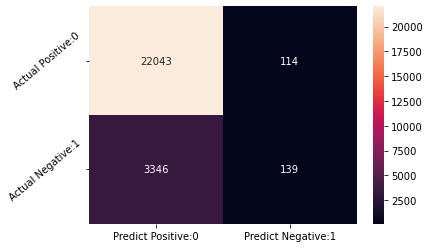

In [321]:
# confusion_matrix of test data
cm = confusion_matrix(Ytest, y_pred)

cm_matrix = pd.DataFrame(data = cm, columns=['Predict Positive:0', 'Predict Negative:1'], 
                         index=['Actual Positive:0', 'Actual Negative:1'])
sns.heatmap(cm_matrix, annot=True, fmt='d')
plt.yticks(rotation=40)

In [322]:
# Randon Forest Classifier Model Accuracy
print("Accuracy:",np.round(accuracy_score(Ytest, y_pred),4))

Accuracy: 0.8651


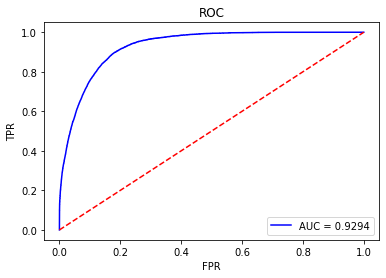

In [323]:
# ROC_AUC Curve of Train Dataset
plot_roc(Ytrain, clf.predict_proba(Xtrain)[:,1])

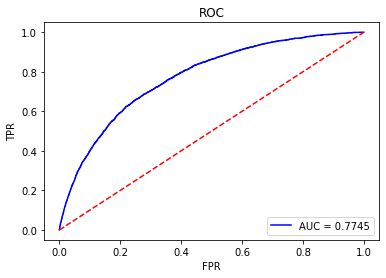

In [324]:
# ROC_AUC Curve of Test Dataset
plot_roc(Ytest, clf.predict_proba(Xtest)[:,1])

In [213]:
def plot_feature_importance(importance, names, model_):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data = {'feature_names':feature_names,'feature_importance':feature_importance}
    dff = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    dff.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(18,9))
    #Plot Searborn bar chart
    sns.barplot(x = dff['feature_importance'], y = dff['feature_names'])
    #Add chart labels
    plt.title(model_ + " " +'Feature Importance',weight='bold')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

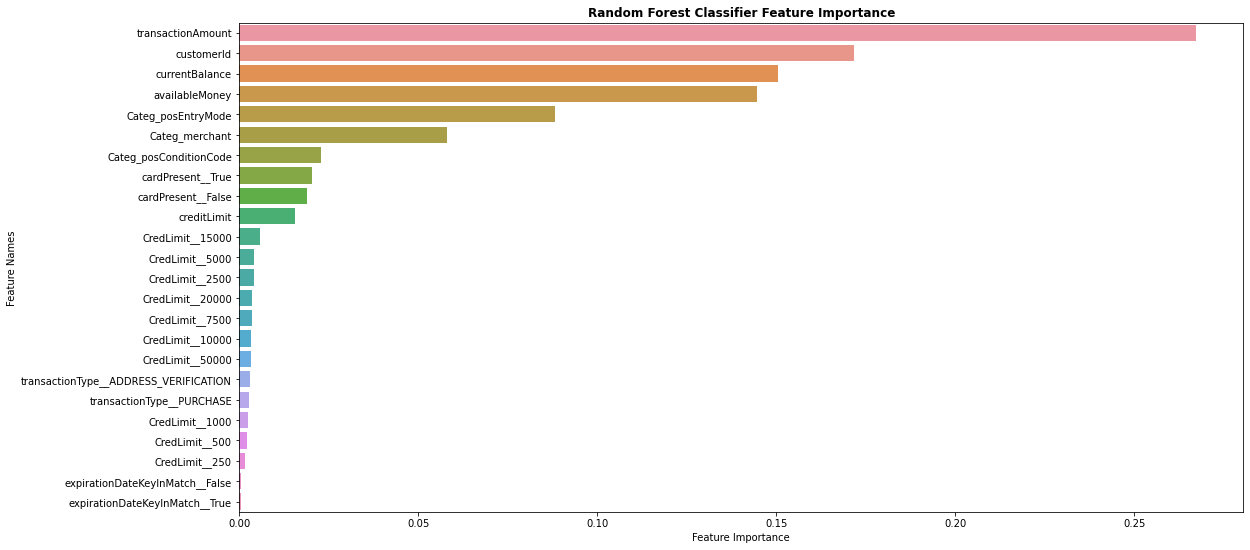

In [214]:
plot_feature_importance(clf.feature_importances_, Xtrain.columns, 'Random Forest Classifier')

#### In Random Forest Classifier Model, these features are relatively important than others when do the detection of fraud transactions 
1. transactionAmount

2. customerld

3. currentBalance

4. availableMoney

5. posEntryMode

6. Categ_merchant

#### Result:

The accuracy of the Random Forest Classifier model was 0.88 on the training dataset, 0.87 on the testing dataset, which indicates that the model is able to correctly classify 87% of transactions as either fraudulent or not fraudulent. The precision of the model was 0.90, which means that out of all the transactions predicted to be fraudulent, 90% of them were actually fraudulent. Also, I chosed the AUC score since it is not affected by imbalanced data. For this Random Forest model, in the training data, the AUC score is 0.9294, in the test data, it's 0.7745. This suggests that there may be overfitting. So I will try XGBoost mext, because it has regularization term to prevent overfitting. I also plot a feature importance graph to understand what features are important to detect fraudulent transactions. I know that transactionAmount, customerld, currentBalance, availableMoney, posEntryMode, Categ_merchant are relatively important than others when do the detection of fraud transactions.

### XGBoost Classifier

##### Using Sklearn XGBoost API do GridSearch

In [225]:
estimator = xgb.XGBClassifier(
    objective= 'binary:logistic',
    seed=666
)

parameters=  { 'max_depth': [5, 9, 13],
               'n_estimators': [500, 700, 900],
               'learning_rate': [0.1, 0.01, 0.001]}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring='f1',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(Xtrain, Ytrain)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [5, 9, 13],
                         'n_estimators': [500, 700, 900]},
             scoring='f1', verbose=True)

In [226]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=13, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=900, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=666, ...)

In [298]:
dtrain = xgb.DMatrix(Xtrain, Ytrain)
dtest = xgb.DMatrix(Xtest, Ytest)

params = {
    'objective' : 'binary:logistic', 
    'booster' : 'gbtree', 
    'eta' : 0.01,
    'max_depth' : 13, 
    'gamma' : 0, 
    'min_child_weight' : 1, 
    'subsample' : 0.8, 
    'colsample_bytree' : 1, 
    'lambda' : 7,
    'eval_metric' : ['error', 'auc'] 
}

watch_list = [(dtrain, 'train'), (dtest, 'test')]


model = xgb.train(params, dtrain, num_boost_round = 1000,
                  evals = watch_list, 
                  early_stopping_rounds = 30, 
                  verbose_eval = False
                 )

In [300]:
# auc score of XGBoost Classifier model
fpr, tpr, threshold = roc_curve(Ytest, model.predict(dtest))
print('XGBoost Classifier model auc score is: ',round(auc(fpr, tpr),4))

XGBoost Classifier model auc score is:  0.793


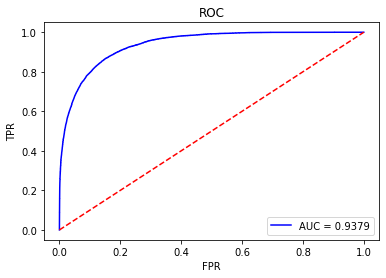

In [301]:
# ROC_AUC Curve of Train Dataset
plot_roc(Ytrain, model.predict(dtrain))

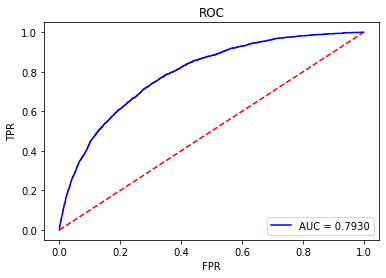

In [302]:
# ROC_AUC Curve of Test Dataset
plot_roc(Ytest, model.predict(dtest))

##### In the training data, the AUC score is 0.9379, in the test data, it's 0.7930. This suggests that there may be overfitting. I tried GridSearch, also implemented regularization, but you know tree models are more prone to overfitting by nature.

In [303]:
importance = model.get_fscore()
importance_new = {i : [importance[i]] for i in importance}
importance_df = pd.DataFrame(importance_new).T.reset_index()
importance_df.columns = ['features', 'feature_importance']
importance_df['feature_importance'] = importance_df['feature_importance']/importance_df['feature_importance'].sum()
importance_df.sort_values(by = 'feature_importance', ascending = False)

,features,feature_importance
3,transactionAmount,0.243296
2,availableMoney,0.225633
0,customerId,0.223792
4,currentBalance,0.164682
13,Categ_posEntryMode,0.024489
14,Categ_posConditionCode,0.018323
15,Categ_merchant,0.017916
1,creditLimit,0.014989
17,cardPresent__False,0.010588
9,CredLimit__7500,0.009282


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

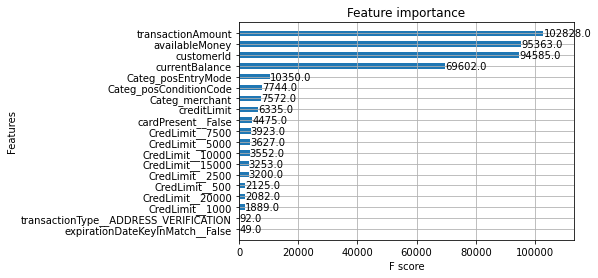

In [304]:
xgb.plot_importance(model, ax = None, height = 0.5)

#### In XGBoost Classifier Model, the same four features are most important as Random Forest Classifier Model, but the importance order changed.
1. transactionAmount

2. availableMoney

3. customerld

4. currentBalance

#### Result:

The performance of the XGBoost model was evaluated using the area under the curve (AUC) score. I chose the AUC score since it is not affected by imbalanced data. For this XGBoost model, in the training data, the AUC score is 0.9379, in the test data, it's 0.7930. This suggests that there may be overfitting. I tried GridSearch, also implemented regularization, so it was better than the Random Forest Model, but you know tree models are more prone to overfitting by nature. To better understand which features are important in detecting fraudulent transactions, I created a feature importance chart. Compared to the Random Forest Classifier, the XGBoost model showed that transactionAmount, availableMoney, customerld and currentBalance were more important in detecting fraudulent transactions.

### Model Performance
So it appears that the XGBoost model performs slightly better than the Random Forest model, due to its ability (like regularization term) to prevent overfitting.

### Next steps for future

With more time, I would explore additional machine learning algorithms, such as neural networks, to see if they could improve the performance of the model.

Tree model are more like overfitting from native. Overly complex models, such as tree models with too many levels, are more prone to overfitting. Simplifying the model by reducing the number of features or levels can help improve its generalization ability, so this also a direction I will try.

I would also investigate the impact of different feature sets on the accuracy of the model and try to identify which features are most important for fraud detection. Additionally, I would experiment with different sampling techniques, such as oversampling or undersampling, to address any imbalances in the dataset. Finally, I would explore the possibility of using additional data sources, such as external fraud databases or transaction logs, to improve the accuracy of the model.


#### Thank you for reviewing my analysis. Wish you a happy work!